In [1]:
from symred.projection import S3_projection, QubitTapering, CS_VQE_LW
from symred.symplectic import *
from symred.utils import exact_gs_energy
from symred.utils import gf2_gaus_elim, gf2_basis_for_gf2_rref
from symred.chem import FermionicHamilt, FermioniCC, PySCFDriver, geometry_from_pubchem
from openfermion import get_fermion_operator, jordan_wigner, hermitian_conjugated, QubitOperator
from matplotlib import pyplot as plt
from functools import reduce
import json

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3

# Calculate the molecule parameters

In [3]:
# Set molecule parameters
speciesname = 'H2O_STO-3G_SINGLET'
#print(speciesname in scoring_data)
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity'] #'6-31g' #'cc-pVDZ' #
charge = mol_data['charge']
geometry = list(zip(atoms, coords))
#geometry = geometry_from_pubchem('N2')

xyz_file = str(len(atoms))+'\n '

for atom, coords in geometry:
    xyz_file += '\n'+atom+'\t'
    xyz_file += '\t'.join(list(map(str, coords)))
#xyz_file = '4\n \nH\t0\t0\t0\nH\t2.45366053071732\t0\t0\nH\t2.45366053071732\t2.45366053071732\t0\nH\t0\t2.45366053071732\t0\n'
print('Molecule geometry:')
print(xyz_file[4:])

Molecule geometry:
O	0	0	0
H	0.952519	0	0
H	-0.246530058	0.9200627021	0


In [4]:
convergence = 1e-6; max_hf_cycles=100_000; ram = 8_000
run_mp2  = True; run_cisd = False; run_ccsd = True; run_fci  = True#False

pyscf_obj = PySCFDriver(xyz_file,
                        basis,
                        #convergence=convergence,
                        charge=charge,
                        #max_ram_memory=ram,
                        #max_hf_cycles=max_hf_cycles,                   
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)

pyscf_obj.run_pyscf()

print('HF converged?  ', pyscf_obj.pyscf_hf.converged)
print('CCSD converged?', pyscf_obj.pyscf_ccsd.converged)
if run_fci:
    print('FCI converged? ', pyscf_obj.pyscf_fci.converged)
    fci_energy = pyscf_obj.pyscf_fci.e_tot
else:
    fci_energy = None
    
hf_energy = pyscf_obj.pyscf_hf.e_tot
mp2_energy = pyscf_obj.pyscf_mp2.e_tot
ccsd_energy = pyscf_obj.pyscf_ccsd.e_tot

print()
print(f'HF energy: {hf_energy}')
print(f'MP2 energy: {mp2_energy}')
print(f'CCSD energy: {ccsd_energy}')
print(f'FCI energy: {fci_energy}')

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy: -74.96203967838713
MP2 energy: -74.99708201366188
CCSD energy: -75.01073164269063
FCI energy: -75.01084664816943


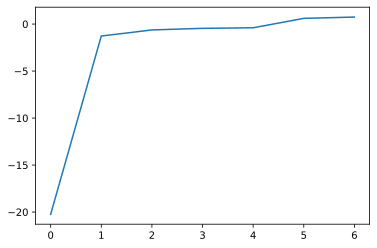

In [5]:
plt.plot(pyscf_obj.pyscf_hf.mo_energy)

# Build the Hamiltonian and Coupled-Cluster operator 

In [6]:
from symred.utils import QubitOperator_to_dict

# build fermionic Hamiltonian
H_fermion = FermionicHamilt(pyscf_obj.pyscf_hf)
T_fermion = FermioniCC(pyscf_obj.pyscf_ccsd)
H_fermion.build_operator()
T_fermion.build_operator()

n_qubits = H_fermion.n_qubits
print('Number of qubits:', n_qubits)

H = get_fermion_operator(H_fermion.fermionic_molecular_hamiltonian)
T = T_fermion.fermionic_cc_operator
#T -= hermitian_conjugated(T)

# map to QubitOperator via Jordan-Wigner
H_jw = jordan_wigner(H)
T_jw = jordan_wigner(T)

# convert to PauliwordOp
H_q = PauliwordOp(QubitOperator_to_dict(H_jw, n_qubits))
T_q = PauliwordOp(QubitOperator_to_dict(T_jw, n_qubits))
T_q.coeff_vec = T_q.coeff_vec.imag

Number of qubits: 14


# Taper the Hamiltonian

In [7]:
taper_hamiltonian = QubitTapering(H_q)

print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
print('The symmetry generators are\n')
print(taper_hamiltonian.symmetry_generators)
print('\nand may be rotated via a sequence of Clifford pi/2 rotations\n')
print(taper_hamiltonian.stabilizers.stabilizer_rotations)
print('\nonto the single-qubit Pauli operators\n')
print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())

We are able to taper 4 qubits from the Hamiltonian.

The symmetry generators are

1.0000000000+0.0000000000j ZIZIIZZIIZZIIZ +
1.0000000000+0.0000000000j IZIZIZIZIZIZIZ +
1.0000000000+0.0000000000j IIIIZZIIIIIIZZ +
1.0000000000+0.0000000000j IIIIIIIIZZIIII

and may be rotated via a sequence of Clifford pi/2 rotations

[('IIIIIIIIYZIIII', None), ('IIIIYZIIIIIIZZ', None), ('YIZIIZZIIZZIIZ', None), ('IYIZIZIZIZIZIZ', None)]

onto the single-qubit Pauli operators

-1.0000000000+0.0000000000j XIIIIIIIIIIIII +
-1.0000000000+0.0000000000j IXIIIIIIIIIIII +
-1.0000000000+0.0000000000j IIIIXIIIIIIIII +
-1.0000000000+0.0000000000j IIIIIIIIXIIIII


In [9]:
hf_array = H_fermion.hf_comp_basis_state
taper_hamiltonian.stabilizers.update_sector(hf_array)
print(f'The symmetry sector corresponding with the reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')

The symmetry sector corresponding with the reference [1 1 1 1 1 1 1 1 1 1 0 0 0 0] is [-1 -1  1  1]


In [10]:
ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
#sor_tap = taper_hamiltonian.taper_it(aux_operator=sor_ham, ref_state=hf_array)
#sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
ucc_tap = taper_hamiltonian.taper_it(aux_operator=T_q, ref_state=hf_array)
n_taper = taper_hamiltonian.n_taper
tapered_qubits   = taper_hamiltonian.stab_qubit_indices
untapered_qubits = taper_hamiltonian.free_qubit_indices
hf_tapered = taper_hamiltonian.tapered_ref_state

print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))

The tapered Hartree-Fock state is  1.0000000000 |1111110000>


# Build the CS-VQE model

In [11]:
cs_vqe_lw = CS_VQE_LW(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap)

# Bias the Hamiltonian around the HOMO-LUMO gap

The HOMO-LUMO gap lies between spin-orbitals 9 and 10


<BarContainer object of 14 artists>

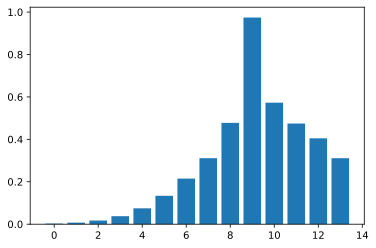

In [12]:
from symred.projection import HamiltonianBiasing, StabilizerIdentification

HL_gap = np.where(hf_array==0)[0][0]-.5
ham_biasing = HamiltonianBiasing(base_operator=H_q, HOMO_LUMO_gap=HL_gap)

ham_biasing.HOMO_bias = .7
ham_biasing.LUMO_bias = .2
#ham_biasing.separation = 1

print(f'The HOMO-LUMO gap lies between spin-orbitals {int(HL_gap-1/2)} and {int(HL_gap+1/2)}')
plt.bar(np.arange(H_q.n_qubits),ham_biasing.HOMO_LUMO_bias_curve())

In [15]:
heatmap_data=[]
steps=50

for a in np.linspace(0, 1, steps):
    print(a)
    for b in np.linspace(0, 1, steps):
        ham_biasing.HOMO_bias = a
        ham_biasing.LUMO_bias = b
        H_bias = taper_hamiltonian.taper_it(aux_operator=ham_biasing.HOMO_LUMO_biased_operator(), ref_state=hf_array)
        stabilizers = StabilizerIdentification(H_bias)
        S = stabilizers.symmetry_basis_by_subspace_dimension(n_sim_qubits=7)
        stab_score = cs_vqe_lw.basis_score(S)
        ham_cs = cs_vqe_lw.project_onto_subspace(S)
        matrix = ham_cs.to_sparse_matrix
        e = exact_gs_energy(matrix)[0]
        error = e-fci_energy
        
        heatmap_data.append((a,b,stab_score,error))

0.0
0.02040816326530612
0.04081632653061224
0.061224489795918366
0.08163265306122448
0.1020408163265306
0.12244897959183673
0.14285714285714285
0.16326530612244897
0.18367346938775508
0.2040816326530612
0.22448979591836732
0.24489795918367346
0.26530612244897955
0.2857142857142857
0.3061224489795918
0.32653061224489793
0.3469387755102041
0.36734693877551017
0.3877551020408163
0.4081632653061224
0.42857142857142855
0.44897959183673464
0.4693877551020408
0.4897959183673469
0.5102040816326531
0.5306122448979591
0.5510204081632653
0.5714285714285714
0.5918367346938775
0.6122448979591836
0.6326530612244897
0.6530612244897959
0.673469387755102
0.6938775510204082
0.7142857142857142
0.7346938775510203
0.7551020408163265
0.7755102040816326
0.7959183673469387
0.8163265306122448
0.836734693877551
0.8571428571428571
0.8775510204081632
0.8979591836734693
0.9183673469387754
0.9387755102040816
0.9591836734693877
0.9795918367346939
1.0


In [51]:
# generate 2 2d grids for the x & y bounds
x,y,z_score,z_error = zip(*heatmap_data)
x = np.array(x).reshape(steps,steps)
y = np.array(y).reshape(steps,steps)
z_score = np.array(z_score).reshape(steps,steps)
z_error = np.array(z_error).reshape(steps,steps)

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


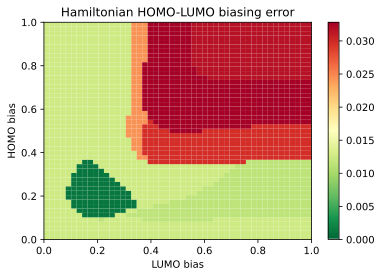

In [52]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z_error, cmap='RdYlGn_r', vmin=0, vmax=z_error.max())
ax.set_title('Hamiltonian HOMO-LUMO biasing error')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel('LUMO bias')
ax.set_ylabel('HOMO bias')
fig.colorbar(c, ax=ax)
plt.show()

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


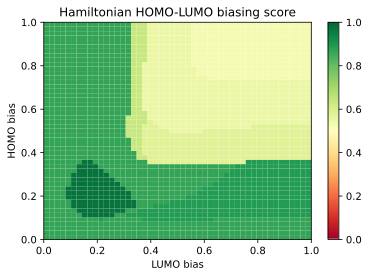

In [56]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z_score, cmap='RdYlGn', vmin=0, vmax=1)
ax.set_title('Hamiltonian HOMO-LUMO biasing score')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel('LUMO bias')
ax.set_ylabel('HOMO bias')
fig.colorbar(c, ax=ax)
plt.show()

In [ ]:
from scipy.optimize import minimize

def find_stabilizers_1(n_sim_qubits):
    
    def stabilizers(a,b,c):
        hlg_op = HLG_op(HOMO_sig=a, LUMO_sig=b, sep=int(c))
        S = find_subspace_for_num_sim_qubits(
            n_sim_qubits, 
            weighting_operator = hlg_op, 
            region=[0,hlg_op.n_terms]
        )
        return(S)
    
    def objective(x):
        S = stabilizers(*x)
        stab_score = cs_vqe_lw.basis_score(S)
        return -stab_score
    
    opt_out = minimize(objective, x0=[1,1,1], bounds=[(.1,10),(.1,10),(1,5)], method='POWELL')
    stab_score=-opt_out['fun']
    print(f'Optimal score w(S)={stab_score}')
    S=stabilizers(*opt_out['x'])
    return S

def find_stabilizers_2(n_sim_qubits):
    
    def stabilizers(a,b):
        hlg_op = HLG_op(HOMO_sig=a, LUMO_sig=b)
        S = find_subspace_for_num_sim_qubits(
            n_sim_qubits, 
            weighting_operator = hlg_op, 
            region=[0,hlg_op.n_terms]
        )
        return(S)
    
    def objective(x):
        S = stabilizers(*x)
        stab_score = cs_vqe_lw.basis_score(S)
        return -stab_score
    
    opt_out = minimize(objective, x0=[.5,.5], bounds=[(.1,np.pi/2),(.1,np.pi/2)], method='POWELL')
    stab_score=-opt_out['fun']
    print(f'Optimal score w(S)={stab_score}')
    S=stabilizers(*opt_out['x'])
    return S
        
#plt.plot(bias_curve(np.arange(ham_tap.n_qubits), u_sig=np.pi/2, l_sig=np.pi/2,sep=10))
print(find_stabilizers_1(7))

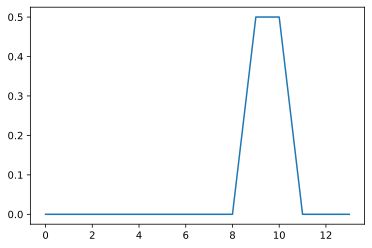

In [213]:
a=.1
b=.1
plt.plot(bias_curve(np.arange(H_q.n_qubits), HOMO_sig=a, LUMO_sig=b))

In [214]:
hlg_op = HLG_op(HOMO_sig=a, LUMO_sig=b, base_op=H_q)
print(hlg_op.sort(key='magnitude'))

0.6933528528+0.0000000000j XIIIIIXIII +
0.5345868926+0.0000000000j IIIXIIXIII +
0.1606914586+0.0000000000j IIIIIIXIII +
-0.0721635242+0.0000000000j XXIIIXIIII +
-0.0594602513+0.0000000000j IXIIIXXIII +
0.0578140453+0.0000000000j IIIIIIXXXX +
0.0510201570+0.0000000000j XXIIIIXXII +
0.0496039843+0.0000000000j IXXIIIXIXI +
-0.0387660963+0.0000000000j IIIIIXXXII +
0.0386746514+0.0000000000j IIXXIIXIIX +
0.0385228969+0.0000000000j XIXIIIXIIX +
-0.0355376894+0.0000000000j IIXIIIXXII +
0.0337225510+0.0000000000j IIIXXIXXII +
-0.0323901973+0.0000000000j IIIIIIXXIX +
0.0323901973+0.0000000000j IIXIIIXXXI +
-0.0318770613+0.0000000000j XIIIIIXIXI +
0.0305041845+0.0000000000j IXIXIIXXII +
0.0305041845+0.0000000000j XIIIXIXXII +
-0.0297301256+0.0000000000j XIIIIXIXII +
0.0288685498+0.0000000000j IIIIXIXIXX +
-0.0280473042+0.0000000000j IIIXXXIIII +
0.0235351598+0.0000000000j IIXIXIXIXI +
-0.0234084873+0.0000000000j XIIIXXIIII +
-0.0234084873+0.0000000000j IXIXIXIIII +
-0.0220615065+0.0000000000j II

Basis score (min:0, max:1): 0.03525855588535542
Number of qubits in contextual subspace: 1/10
Error from FCI: 0.04880696977510013
Basis score (min:0, max:1): 0.5928891367114825
Number of qubits in contextual subspace: 2/10
Error from FCI: 0.03640635295077743
Basis score (min:0, max:1): 0.6625000863018611
Number of qubits in contextual subspace: 3/10
Error from FCI: 0.03233688601321205
Basis score (min:0, max:1): 0.766047032483043
Number of qubits in contextual subspace: 4/10
Error from FCI: 0.025451033976267468
Basis score (min:0, max:1): 0.8069809091279408
Number of qubits in contextual subspace: 5/10
Error from FCI: 0.020464346615838735
Basis score (min:0, max:1): 0.8638830809076037
Number of qubits in contextual subspace: 6/10
Error from FCI: 0.01240093825232691
Basis score (min:0, max:1): 0.9763728986066011
Number of qubits in contextual subspace: 7/10
Error from FCI: 0.001137704680331808
Basis score (min:0, max:1): 0.9999538429324422
Number of qubits in contextual subspace: 8/10
E

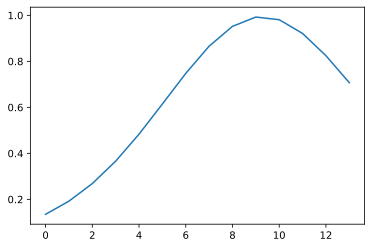

In [166]:
ref_energy = fci_energy
max_sim_q = 10
a=1.4
b=1.3

scores = []
energy = []

for i in range(1, ham_tap.n_qubits):
    try:
        #stabilizers =  find_stabilizers_1(n_sim_qubits=i)
        hlg_op = HLG_op(HOMO_sig=a, LUMO_sig=b, base_op=H_q)
        stabilizers = find_subspace_for_num_sim_qubits(
            i, 
            weighting_operator = hlg_op, 
            region=[0,hlg_op.n_terms]
        )
        stab_score = cs_vqe_lw.basis_score(stabilizers)
        scores.append(stab_score)
        print('Basis score (min:0, max:1):', stab_score)
        if i<=max_sim_q:
            ham_cs = cs_vqe_lw.project_onto_subspace(stabilizers)
            print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')
            matrix = ham_cs.to_sparse_matrix
            e = exact_gs_energy(matrix)[0]
            print('Error from FCI:', e-ref_energy)
            energy.append(e)
    except:
        print(i, 'did not work')

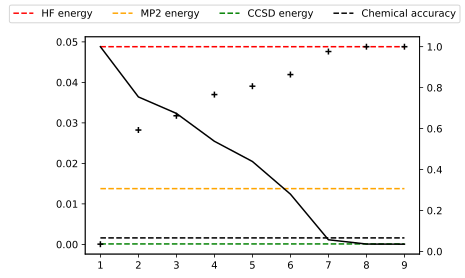

In [167]:
from matplotlib import pyplot as plt
#plt.style.use('ggplot')

fig,energy_axis = plt.subplots()
X=np.arange(1, ham_tap.n_qubits)

Y_energy=np.array(energy)-ref_energy
energy_axis.plot(X[:max_sim_q], Y_energy, color='black')
energy_axis.hlines(hf_energy-ref_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(mp2_energy-ref_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(ccsd_energy-ref_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_ylim(1e-15, 1e-0) 
#energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
Y_scores=np.array(scores)
score_axis.scatter(X, Y_scores, color='black', marker='+')

#energy_axis.set_xticks(X)

fig.legend(ncol=4)
plt.show()

In [58]:
np.tan(np.pi/2)

1.633123935319537e+16

In [252]:
HL_gap = np.where(hf_tapered==0)[0][0]
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

bias=1
HL_bias = gaussian(np.arange(0,ucc_tap.n_qubits), HL_gap-0.5, bias)
HL_biased_coeffs = np.sum(ucc_tap.X_block*HL_bias, axis=1)*ucc_tap.coeff_vec
hlg_op = PauliwordOp(ucc_tap.symp_matrix, HL_biased_coeffs)

hlg_op = HLG_op(u_sig=1, l_sig=1, sep=2)

ucc_sort = ucc_tap.sort(key='magnitude')
ham_sort = ham_tap.sort(key='magnitude')
hlg_sort = hlg_op.sort(key='magnitude')
print(hlg_sort)

def stabilizers_by_term_significance(n_terms, weighting_operator):
    preserve = weighting_operator.sort(key='magnitude')[:n_terms]# + cs_vqe.clique_operator[1]
    ZX_symp = np.hstack([preserve.Z_block, preserve.X_block])
    reduced = gf2_gaus_elim(ZX_symp)
    kernel  = gf2_basis_for_gf2_rref(reduced)
    stabilizers = StabilizerOp(kernel, np.ones(kernel.shape[0]))
    mask_diag = np.where(~np.any(stabilizers.X_block, axis=1))[0]
    return StabilizerOp(stabilizers.symp_matrix[mask_diag], stabilizers.coeff_vec[mask_diag])

def find_stabilizers(n_sim_qubits, weighting_operator=hlg_sort, region=[0,hlg_sort.n_terms]):
    assert(n_sim_qubits < ham_tap.n_qubits), 'Number of qubits to simulate exceeds those in the operator'
    assert(region[1]-region[0]>1), 'Search region collapsed without identifying any stabilizers'
    n_terms = sum(region)//2
    stabilizers = stabilizers_by_term_significance(n_terms, weighting_operator)
    current_n_qubits = ham_tap.n_qubits - stabilizers.n_terms
    sign = np.sign(current_n_qubits - n_sim_qubits)
    
    if sign==0:
        # i.e. n_sim_qubits == current_n_qubits
        return stabilizers
    elif sign==+1:
        # i.e. n_sim_qubits < current_n_qubits
        region[1] = n_terms
    else:
        region[0] = n_terms
    return find_stabilizers(n_sim_qubits, weighting_operator, region)

-0.5959289233+0.0000000000j IIIIXIIXII +
-0.5212144753+0.0000000000j XIIIIIXIII +
-0.4879606760+0.0000000000j IXIIIIIXII +
-0.4585053839+0.0000000000j IIIXIIXIII +
-0.0948156846+0.0000000000j IIXIIIIIIX +
0.0737520503+0.0000000000j IXIIXIIIII +
-0.0604674278+0.0000000000j IXIXIIXXII +
0.0595195241+0.0000000000j IIIIXIXIXX +
0.0461844528+0.0000000000j IIXIXIXIXI +
-0.0461484797+0.0000000000j IIXXIIXIIX +
-0.0334519125+0.0000000000j IIXIIIXXII +
-0.0326950247+0.0000000000j XXIIIXIIII +
-0.0325409842+0.0000000000j IIIIIIXIII +
0.0320986691+0.0000000000j IIIIIIXXIX +
0.0304559439+0.0000000000j IIIIIIIXII +
-0.0295059933+0.0000000000j IIIIIIXXII +
0.0278573814+0.0000000000j IXIIIXXIII +
-0.0269387143+0.0000000000j IIIIIXXXII +
-0.0269315689+0.0000000000j XIIIIXIXII +
-0.0251521730+0.0000000000j XIIIIIIXIX +
-0.0232812685+0.0000000000j XIIIIIXIXI +
-0.0229482583+0.0000000000j IIXIXIIXIX +
-0.0226849306+0.0000000000j XIIXXIIXII +
-0.0211325391+0.0000000000j IIIXXXIIII +
-0.0174468709+0.000000

In [253]:
ref_energy = fci_energy
max_sim_q = 10

scores = []
energy = []

for i in range(1, ham_tap.n_qubits):
    try:
        stabilizers =  find_stabilizers(n_sim_qubits=i, region=[0,hlg_sort.n_terms])
        stab_score = cs_vqe_lw.basis_score(stabilizers)
        scores.append(stab_score)
        print('Basis score (min:0, max:1):', stab_score)
        if i<=max_sim_q:
            ham_cs = cs_vqe_lw.project_onto_subspace(stabilizers)
            print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')
            matrix = ham_cs.to_sparse_matrix
            e = exact_gs_energy(matrix)[0]
            print('Error from CCSD:', e-ref_energy)
            energy.append(e)
    except:
        print(i, 'did not work')

Basis score (min:0, max:1): 0.1419525846148868
Number of qubits in contextual subspace: 1/10
Error from CCSD: 0.048806969752106966
Basis score (min:0, max:1): 0.22851418193310682
Number of qubits in contextual subspace: 2/10
Error from CCSD: 0.04699839483291157
Basis score (min:0, max:1): 0.28794959296567135
Number of qubits in contextual subspace: 3/10
Error from CCSD: 0.043209247782556304
Basis score (min:0, max:1): 0.4423301667943326
Number of qubits in contextual subspace: 4/10
Error from CCSD: 0.03785108778579627
Basis score (min:0, max:1): 0.5444808339282734
Number of qubits in contextual subspace: 5/10
Error from CCSD: 0.030662392221358914
Basis score (min:0, max:1): 0.6341518543595178
Number of qubits in contextual subspace: 6/10
Error from CCSD: 0.02436287673459958
Basis score (min:0, max:1): 0.9763728986065998
Number of qubits in contextual subspace: 7/10
Error from CCSD: 0.0011377046799907475
Basis score (min:0, max:1): 0.9999538429324424
Number of qubits in contextual subsp

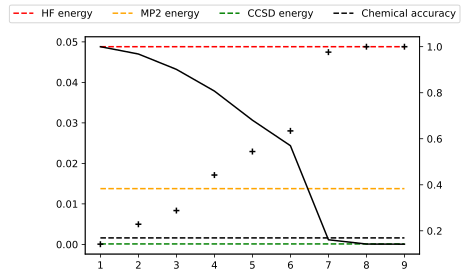

In [254]:
from matplotlib import pyplot as plt
#plt.style.use('ggplot')

fig,energy_axis = plt.subplots()
X=np.arange(1, ham_tap.n_qubits)

Y_energy=np.array(energy)-ref_energy
energy_axis.plot(X[:max_sim_q], Y_energy, color='black')
energy_axis.hlines(hf_energy-ref_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(mp2_energy-ref_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(ccsd_energy-ref_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_ylim(1e-15, 1e-0) 
#energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
Y_scores=np.array(scores)
score_axis.scatter(X, Y_scores, color='black', marker='+')

#energy_axis.set_xticks(X)

fig.legend(ncol=4)
plt.show()

In [42]:
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)
    
#scoring_data

In [43]:
#speciesname = 'H2O_6-31g_SINGLET'

#scoring_data[speciesname] = {
#    'n_qubits_pre_taper': H_q.n_qubits, 
#    'n_qubits_post_taper': ham_tap.n_qubits,
#    'hf_energy': hf_energy,
#    'mp2_energy': mp2_energy,
#    'ccsd_energy': ccsd_energy,
#    'fci_energy': fci_energy,
#    'cs_vqe_energies': energy,
#    'stabilizer_score': scores
#}

#scoring_data

In [44]:
#with open('data/score_data.json', 'w') as outfile:
#    json.dump(scoring_data, outfile)

In [17]:
from scipy.special import comb

def random_stabs(n_stabs):
    Z_block = np.random.randint(0,2,(n_stabs, ham_tap.n_qubits))
    S = StabilizerOp(np.hstack([np.zeros_like(Z_block), Z_block]), np.ones(n_stabs))
    return S

def score_vs_energy(n_stabs):
    S = random_stabs(n_stabs)
    ucc_stab_score = cs_vqe_lw.basis_score(S)
    ham_stab_score = cs_vqe_lw_2.basis_score(S)
    ham_cs = cs_vqe_lw.project_onto_subspace(S)
    matrix = ham_cs.to_sparse_matrix
    e = exact_gs_energy(matrix)[0]
    return ham_stab_score, ucc_stab_score, e

data={}

for n_stabs in range(1, ham_tap.n_qubits):
    print(f'Randomizing {n_stabs} stabilizer(s)')
    count=0
    results = []
    while count<=2**ham_tap.n_qubits:
        try:
            results.append(score_vs_energy(n_stabs))
            count+=1
        except:
            pass
    data[ham_tap.n_qubits-n_stabs] = results

Randomizing 1 stabilizer(s)
Randomizing 2 stabilizer(s)
Randomizing 3 stabilizer(s)
Randomizing 4 stabilizer(s)
Randomizing 5 stabilizer(s)
Randomizing 6 stabilizer(s)
Randomizing 7 stabilizer(s)
Randomizing 8 stabilizer(s)


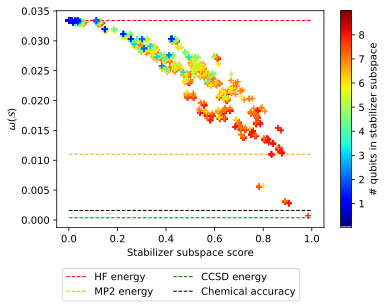

In [23]:
from matplotlib.pyplot import Normalize

fig,axis = plt.subplots()

increments = []

for n_qubits,results in data.items():
    ratio = n_qubits/ham_tap.n_qubits
    increments.append(ratio)
    c = plt.cm.jet(ratio)
    X_ham, X_ucc, Y = zip(*results)
    X = np.array(X_ucc)
    Y = np.array(Y) - fci_energy
    axis.scatter(
        X, 
        Y, 
        marker='+', 
        color=c, 
        zorder=1,#n_qubits,
        alpha=0.9)
    
keys = list(data.keys())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                     ax=axis, label='# qubits in stabilizer subspace', ticks=increments)#, fraction=0.78)
cbar.ax.set_yticklabels(keys)

axis.set_xlabel('Stabilizer subspace score')
axis.set_ylabel('$\omega(\mathcal{S})$')

axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')

fig.legend(ncol=2, bbox_to_anchor=(0.7,0))

In [31]:
#with open('data/score_vs_energy.json', 'r') as infile:
#    score_vs_energy = json.load(infile)
#    
#score_vs_energy.keys()

In [32]:
#score_vs_energy[speciesname] = {
#    'n_qubits_pre_taper': H_q.n_qubits, 
#    'n_qubits_post_taper': ham_tap.n_qubits,
#    'hf_energy': hf_energy,
#    'mp2_energy': mp2_energy,
#    'ccsd_energy': ccsd_energy,
#    'fci_energy': fci_energy,
#    'ham_score_ucc_score_cs_energy':data
#}
#score_vs_energy

In [33]:
#with open('data/score_vs_energy.json', 'w') as outfile:
#    json.dump(score_vs_energy, outfile)